# Lecture : Introduction to Graph Science

## Lab 01 : Generate artificial LFR social networks -- Exercise

### Xavier Bresson, Nian Liu


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2025_codes/codes/02_Graph_Science'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    

In [1]:
# Load libraries
import numpy as np
%matplotlib inline
#%matplotlib notebook 
import matplotlib.pyplot as plt
import subprocess # print output of LFR code
import scipy.sparse # sparse matrix
import scipy.sparse.linalg
import pylab # 3D visualization
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
from lib import *
import warnings; warnings.filterwarnings("ignore")
import platform


### Question 1 : Define a LFR graph by selecting the hyper-parameters
https://github.com/eXascaleInfolab/LFR-Benchmark_UndirWeightOvp

* N : Number of nodes
* k : Number of communities
* maxc : Maximum size of community
* minc : Minimum size of community
* mu : Mixing parameter between communities (the lower the less mix the communities)
  

In [2]:
# LFR parameters
N = 1000 # YOUR CODE HERE 
k = maxk = 10 # YOUR CODE HERE 

# different community sizes
alpha = 0.5
minc = round((1-alpha)*N/k)
maxc = round((1+alpha)*N/k)

# mixing parameter
mu = 0.1

print('N, k, minc, maxc, mu :', N, k, minc, maxc, mu)


N, k, minc, maxc, mu : 1000 10 50 150 0.1


In [3]:
print('os is :', platform.system())
if platform.system()!='Windows': # os is not Windows
    # Compile LFR code
    !{'cd LFR; make; cd ..'}
    # Run LFR code
    cmd = './LFR/benchmark -N ' + str(N) + ' -k ' + str(k) + ' -maxk ' + str(maxk) + \
    ' -mu ' + str(mu) + ' -minc ' + str(minc) + ' -maxc ' + str(maxc)
    print(cmd)
    !{cmd}
    # Get path to generated dataset
    path_dataset = './'
else: # os is Windows
    print('LFR cannot be compiled under Windows -- Using saved dataset instead')
    path_dataset = 'datasets/'


os is : Windows
LFR cannot be compiled under Windows -- Using saved dataset instead


In [22]:
# Read LFR data:
#     'community.dat' contains the ground truth of communities from 1 to K
#     'network.dat' contains the edges of the LFR network

community = np.loadtxt(path_dataset + 'community.dat')
community = community[:,1]
print('nb of nodes=',community.shape[0])

network = np.loadtxt(path_dataset + 'network.dat') 
network -= 1 # index starts at 0 with python
print('nb of edges=',network.shape[0])


nb of nodes= 1000
nb of edges= 10000


In [23]:
# community: a list of community indices for each node
# network: a list of edges (i,j) with i,j the indices of the nodes
print(community.shape, network.shape)

(1000,) (10000, 2)


In [24]:
# explore the data
print(community[:10])
print(network[:10])

[ 6.  7.  7.  3. 10.  3.  1.  2.  9.  6.]
[[  0. 131.]
 [  0. 223.]
 [  0. 251.]
 [  0. 423.]
 [  0. 472.]
 [  0. 553.]
 [  0. 653.]
 [  0. 970.]
 [  0. 976.]
 [  0. 996.]]


### Question 2 : Construct a sparse graph with the scipy library
https://docs.scipy.org/doc/scipy/reference/sparse.html

Compute a sparse matrix W which represents the adjacency matrix of a LFR network.

For example, `W = scipy.sparse.csr_matrix((data, (row_ind, col_ind)), shape)` where
https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

* row_ind : Vector representing the node index of the starting edge i, i.e. the row index of W.
* col_ind : Vector representing the node index of the ending edge j, i.e. the column index of W.
* data : The value of edge ij.

At last, print the shape and type of the spare matrix. 


In [25]:
# Create LFR adjacency matrix W
nv = community.shape[0] # nb of vertices
ne = network.shape[0] # edge (i, j)
#print(nv,ne)

# row: first column of network
# col: second column of network
# data: 1 for each edge
row = network[:,0]
col = network[:,1]
data = np.ones([ne])

W = scipy.sparse.csr_matrix((data, (row, col)), shape=(nv, nv))
print(W.shape,type(W))



(1000, 1000) <class 'scipy.sparse._csr.csr_matrix'>


### Question 3 : Plot the computed sparse adjacency matrix W.

Function is `spy()` from matplotlib:

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.spy.html

Does it reveal any interesting structure?

Ans: No, because the index are random


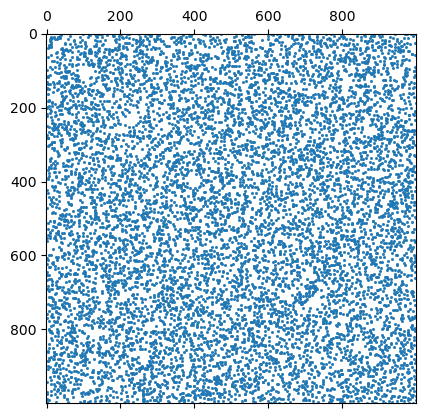

In [26]:
# Plot adjacency matrix
plt.figure(1)
plt.spy(W, precision=0.01, markersize=1)
plt.show()


In [27]:
######################################
# Function that reindexes W according to communities/classes
######################################

######################################
# Usage: 
#   [reindexed_W,reindexed_C] = reindex_W_with_C(W,C)
#
# Notations:
#   n = nb_data
#   nc = nb_communities
#
# Input variables:
#   W = Adjacency matrix. Size = n x n.
#   C = Classes used for reindexing W. Size = n x 1. Values in [0,1,...,nc-1].
#
# Output variables:
#   reindexed_W = reindexed adjacency matrix. Size = n x n.
#   reindexed_C = reindexed classes C. Size = n x 1. Values in [0,1,...,nc-1].
######################################

def reindex_W_with_classes(W,C):
    n = C.shape[0] # nb of vertices
    nc = len(np.unique(C)) # nb of communities
    reindexing_mapping = np.zeros([n]) # mapping for reindexing W
    reindexed_C = np.zeros([n]) # reindexed C
    tot = 0
    for k in range(nc):
        cluster = (np.where(C==k))[0]
        length_cluster = len(cluster)
        x = np.array(range(tot,tot+length_cluster))
        reindexing_mapping[cluster] = x
        reindexed_C[x] = k
        tot += length_cluster
        
    idx_row,idx_col,val = scipy.sparse.find(W)
    idx_row = reindexing_mapping[idx_row]
    idx_col = reindexing_mapping[idx_col]
    reindexed_W = scipy.sparse.csr_matrix((val, (idx_row, idx_col)), shape=(n, n))

    return reindexed_W,reindexed_C
    

In [28]:
# community indices start at 1
# -1 to start at 0
C = community - 1
[W,C] = reindex_W_with_classes(W,C)


### Question 4 : Plot the adjacency matrix W re-indexed with the ground truth communities.

Does it reveal any interesting structure?


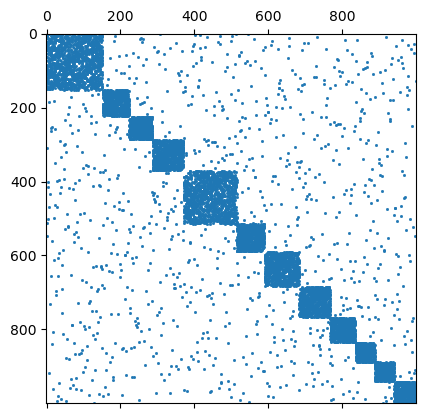

In [29]:
# Plot same W but according to communities
plt.figure(2)
plt.spy(W,precision=0.01, markersize=1)
plt.show()


### Comment : The rest of the notebook if for visualizing the graph in 2D and 3D spaces

We will study graph visualization later.


In [30]:
######################################
# Graph Laplacian Operator
######################################

######################################
# Usages: 
#   L = compute_graph_laplacian(W); # compute normalized graph Laplacian
#   L = compute_graph_laplacian(W,False); # compute UNnormalized graph Laplacian
#
# Notations:
#   n = nb_data
#
# Input variables:
#   W = Adjacency matrix. Size = n x n.
#
# Output variables:
#   L = Graph Laplacian. Size = n x n.
######################################

def graph_laplacian(W, normalized=True):
    
    # Degree vector
    d = W.sum(axis=0)

    # Laplacian matrix
    if not normalized:
        D = scipy.sparse.diags(d.A.squeeze(), 0)
        L = D - W
    else:
        d += np.spacing(np.array(0, W.dtype)) # d += epsilon
        d = 1.0 / np.sqrt(d)
        D = scipy.sparse.diags(d.A.squeeze(), 0)
        I = scipy.sparse.identity(d.size, dtype=W.dtype)
        L = I - D * W * D
    return L
    

In [31]:
######################################
# Visualization technique:
#   Belkin-Niyogi, Laplacian eigenmaps for dimensionality reduction and data representation, 2003
######################################

######################################
# Usage: 
#   [X,Y,Z] = compute_non_linear_dim_reduction(W)
#
# Notations:
#   n = nb_data
#
# Input variables:
#   W = Adjacency matrix. Size = n x n.
#
# Output variables:
#   X = 1st data coordinates in low-dim manifold. Size n x 1.
#   Y = 2nd data coordinates in low-dim manifold. Size n x 1.
#   Z = 3rd data coordinates in low-dim manifold. Size n x 1.
######################################

def sort(lamb, U):
    idx = lamb.argsort()
    return lamb[idx], U[:,idx]

def compute_non_linear_dim_reduction(W):
    
    # Compute normalized graph Laplacian
    L = graph_laplacian(W)
    
    # Regularization for ill-posed graphs
    L = L + 1e-6* scipy.sparse.identity(L.shape[0], dtype=W.dtype)

    # Compute the first three Laplacian Eigenmaps
    lamb, U = scipy.sparse.linalg.eigsh(L, k=4, which='SM')
    
    # Sort eigenvalue from smallest to largest values
    lamb, U = sort(lamb, U)
    
    # Coordinates of graph vertices in the low-dim embedding manifold
    X = U[:,1]
    Y = U[:,2]
    Z = U[:,3]

    return X,Y,Z

[X,Y,Z] = compute_non_linear_dim_reduction(W)
#print(X.shape)


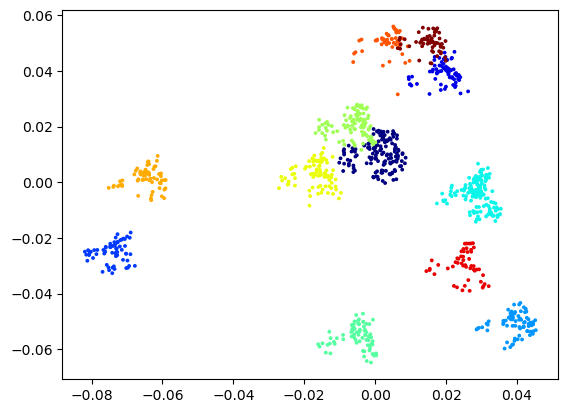

In [32]:
# Visualize the social network in 2D
plt.figure(3)
plt.scatter(X, Y, c=C, s=3, color=pyplot.jet())
plt.show()


In [33]:
# 3D Visualization
import plotly.graph_objects as go
data = go.Scatter3d(x=X, y=Y, z=Z, mode='markers', marker=dict(size=3, color=C, colorscale='jet', opacity=1)) # data as points
# data = go.Scatter3d(x=Xvis, y=Yvis, z=Zvis, mode='markers', marker=dict(size=1, color=C, colorscale='jet', opacity=1, showscale=True)) # w/ colobar 
fig = go.Figure(data=[data]) 
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30, pad=0)) # tight layout but t=25 required for showing title 
fig.update_layout(autosize=False, width=600, height=600, title_text="3D visualization of LFR graph") # figure size and title
# fig.update_layout(scene = dict(xaxis = dict(visible=False), yaxis = dict(visible=False), zaxis = dict(visible=False))) # no grid, no axis 
# fig.update_layout(scene = dict(xaxis_title = ' ', yaxis_title = ' ', zaxis_title = ' ')) # no axis name 
fig.update_layout(scene = dict(zaxis = dict(showgrid = True, showticklabels = False), zaxis_title = ' ') ) # no range values, no axis name, grid on
fig.update_layout(scene = dict(yaxis = dict(showgrid = True, showticklabels = False), yaxis_title = ' ') ) # no range values, no axis name, grid on
fig.update_layout(scene = dict(xaxis = dict(showgrid = True, showticklabels = False), xaxis_title = ' ') ) # no range values, no axis name, grid on
fig.layout.scene.aspectratio = {'x':1, 'y':1, 'z':1}
fig.show()
